In [7]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import os

In [3]:
client = MongoClient("mongodb://127.0.0.1:27017/?directConnection=true&serverSelectionTimeoutMS=2000&appName=mongosh+2.3.4")
print(client.list_database_names())

['admin', 'config', 'local']


In [25]:
import numpy as np
import pandas as pd
import os

# Define categories
bird_categories = ['seagull', 'pigeon', 'raven', 'black-headed gull', 'seagull and black-headed gull', 'heron']
drone_categories = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6']
target_categories = bird_categories + drone_categories

# Load the radar data with allow_pickle=True
radar_data = np.load(r"D:\SIH\Cloud_ML_Integration\Reinforcement-Learning\Data_Set\Data_Set.npy", allow_pickle=True)

# Convert to DataFrame
df = pd.DataFrame(radar_data)

# Create output directory
output_dir = r"D:\SIH\Cloud_ML_Integration\Reinforcement-Learning\radar_data"
os.makedirs(output_dir, exist_ok=True)

# Counters for statistics
bird_count = 0
drone_count = 0

# Process and save data
for idx, row in df.iterrows():
    if row[0] in target_categories:
        # Create label (0 for birds, 1 for drones)
        label = 1 if row[0] in drone_categories else 0
        
        # Get complex data
        complex_data = row[1]
        
        # Create data array with label and complex data
        row_data = np.array([label, complex_data], dtype=object)
        
        # Generate filename
        category_prefix = 'bird_' if label == 0 else 'drone_'
        filename = f"{category_prefix}data_row_{idx}.npy"
        filepath = os.path.join(output_dir, filename)
        
        # Save with allow_pickle=True
        np.save(filepath, row_data, allow_pickle=True)
        
        # Update counters
        if label == 0:
            bird_count += 1
        else:
            drone_count += 1

print(f"Total birds saved: {bird_count}")
print(f"Total drones saved: {drone_count}")


Total birds saved: 56
Total drones saved: 44


C:\Users\hp\AppData\Local\Temp\ipykernel_5620\2107638313.py:24: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=35).
  ax.specgram(magnitude_data, Fs=1.0)


KeyboardInterrupt: 

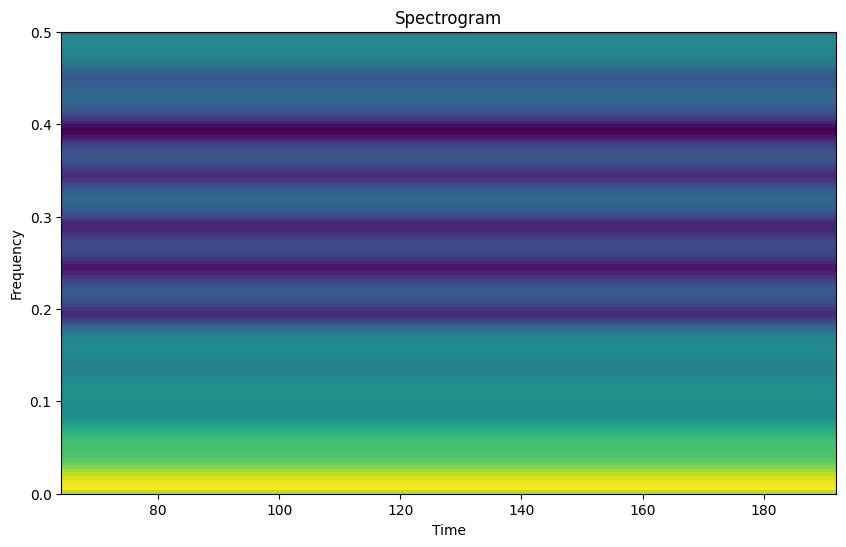

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from PIL import Image
import tensorflow as tf
from io import BytesIO

def process_radar_data(file_path):
    # Load the numpy file
    data = np.load(file_path, allow_pickle=True)
    labels = data[0]  # First element is the label
    complex_values = data[1] 
    
    def generate_spectrogram(complex_data):
        # Convert complex data to magnitude
        magnitude_data = np.abs(complex_data)
        
        # Handle multi-dimensional data
        if magnitude_data.ndim > 1:
            magnitude_data = magnitude_data.mean(axis=-1).flatten()
            
        # Create spectrogram
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.specgram(magnitude_data, Fs=1.0)
        ax.set_title('Spectrogram')
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        
        # Save to buffer
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plt.close(fig)
        return buf
    
    def preprocess_spectrogram(spectrogram_buf):
        # Open and convert to grayscale
        img = Image.open(spectrogram_buf).convert("L")
        img = img.resize((224, 224))
        img = img.convert("RGB")
        
        # Convert to numpy array and normalize
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    
    processed_data = []
    for complex_value in complex_values:
        # Generate spectrogram
        spectrogram_buf = generate_spectrogram(complex_value)
        
        # Preprocess spectrogram
        processed_sample = preprocess_spectrogram(spectrogram_buf)
        processed_data.append(processed_sample)
    
    return np.vstack(processed_data), labels

def predict_radar_data(model_path, data_path):
    model = tf.keras.models.load_model(model_path)
    processed_data, labels = process_radar_data(data_path)
    predictions = model.predict(processed_data)
    return predictions, labels

# Usage example
if __name__ == "__main__":
    MODEL_PATH = r"D:\SIH\Cloud_ML_Integration\Reinforcement-Learning\model\serial_network_model_combined.keras"
    DATA_PATH = r"radar_data/bird_data_row_55.npy"
    
    predictions, original_labels = predict_radar_data(MODEL_PATH, DATA_PATH)
    
    # Print results
    for i, (pred, label) in enumerate(zip(predictions, original_labels)):
        print(f"Sample {i}: Prediction = {pred}, Original Label = {label}")
